In [12]:
%matplotlib notebook
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import torchvision as tv
from PIL import Image
import matplotlib.pyplot as plt
import nntools as nt
import pandas as pd
import torch.optim as optim


from ResNetGenerator import ResNetGen

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


cuda


In [4]:
dataset_root_dir = "/datasets/COCO-2015"

In [5]:
from os import listdir
from os.path import isfile, join
listdir(dataset_root_dir)

['val2014', 'test2015', 'train2014']

In [6]:
style_root_dir = "./style"

In [7]:
class styleImage():
    def __init__(self, root_dir, image_name ,image_size=(256, 256)):
        self.image_size = image_size
        self.images_dir = join(root_dir, image_name)
    def __getitem__(self, idx):
        img = Image.open(self.images_dir)
        transform = tv.transforms.Compose([
            # COMPLETE
            tv.transforms.Resize(self.image_size),
            tv.transforms.ToTensor(),
#             tv.transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                   std=[0.229, 0.224, 0.225])]
             tv.transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                  std=[0.5, 0.5, 0.5])]
        )
        x = transform(img).unsqueeze(0)
        return x

In [8]:
def recover_image(img):
    return (
        (
#             img *
#             np.array([0.229, 0.224, 0.225]).reshape((1, 3, 1, 1)) +
#             np.array([0.485, 0.456, 0.406]).reshape((1, 3, 1, 1))
            
            img *
            np.array([0.5, 0.5, 0.5]).reshape((1, 3, 1, 1)) +
            np.array([0.5, 0.5, 0.5]).reshape((1, 3, 1, 1))
        ).transpose(0, 2, 3, 1) *
        255.
    ).clip(0, 255).astype(np.uint8)

<IPython.core.display.Javascript object>


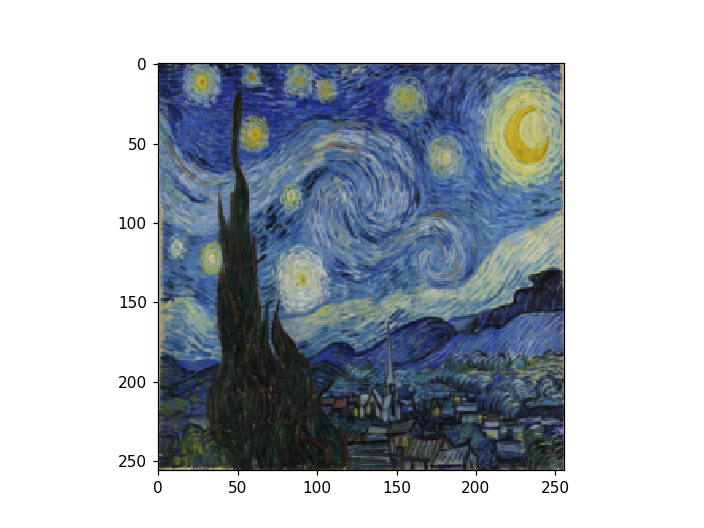

In [9]:
style_img = styleImage(style_root_dir,"the_starry_night.jpg")
style_img = style_img.__getitem__(0)
plt.figure(4)
plt.imshow(recover_image(style_img.cpu().numpy())[0])

In [19]:
new_net = ResNetGen(3,3,32,"reflect","BatchNorm",False,5,2)

In [20]:
new_net.load_state_dict(torch.load('./ResNetTrained'))
new_net.eval()
new_net.to(device)

ResNetGen(
  (net): Sequential(
    (0): ReflectionPad2d((4, 4, 4, 4))
    (1): Conv2d(3, 32, kernel_size=(9, 9), stride=(1, 1))
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): ResidualBlock(
      (forward_func): Sequential(
        (0): ConvLayer(
          (forward_func): Sequential(
            (0): ReflectionPad2d((1, 1, 1, 1))
            (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
          )
        )
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
   

In [15]:
class COCODataset(td.Dataset):
    def __init__(self, root_dir, mode="train", image_size=(256, 256),small_scale=True):
        super(COCODataset, self).__init__()
        
#################################################################

#     root_dir:          root directory of the training set 
#     mode:              mode, train or validation(not used in this project) 
#     image_size:         length and withd of the output image 
#     small_scale=True:   if small scale is set to True, the loader only load 
#                         1/10 of the training data


#################################################################
        self.image_size = image_size
        self.mode = mode
        if mode == "train":
            image_dir = join(root_dir, "train2014")     
        else:
            image_dir = join(root_dir,"val2014")
        index = 0
        data_dict = {}
        for file in listdir(image_dir):
            if file.endswith(".jpg"):
                data_dict[index]= join(image_dir,file)
                index += 1
        self.data = pd.Series(data_dict)
        if small_scale:
            self.data = self.data.iloc[:(len(self.data)//10)]
    def __len__(self):
        return len(self.data)
    def __repr__(self):
        return "COCODataset(mode={}, image_size={})". \
            format(self.mode, self.image_size)
    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]
        img = Image.open(img_path).convert('RGB')
        transform = tv.transforms.Compose([tv.transforms.Resize(self.image_size),
                                           tv.transforms.ToTensor(),
#                                            tv.transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                   std=[0.229, 0.224, 0.225])
                                           tv.transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                  std=[0.5, 0.5, 0.5])
                                        ])
        x = transform(img)
        return x

In [21]:
train_COCO = COCODataset(dataset_root_dir,small_scale=True)
train_loader = td.DataLoader(train_COCO, batch_size=4, shuffle=True,drop_last=True)

In [28]:
x = train_COCO.__getitem__(11)
y = train_COCO.__getitem__(10)
z = train_COCO.__getitem__(1)

x = x.unsqueeze(0)
x = x.to(device)
y = y.unsqueeze(0)
y = y.to(device)
z = z.unsqueeze(0)
z = z.to(device)

In [29]:
out_img_x = new_net(x)
out_img_y = new_net(y)
out_img_z = new_net(z)

<IPython.core.display.Javascript object>


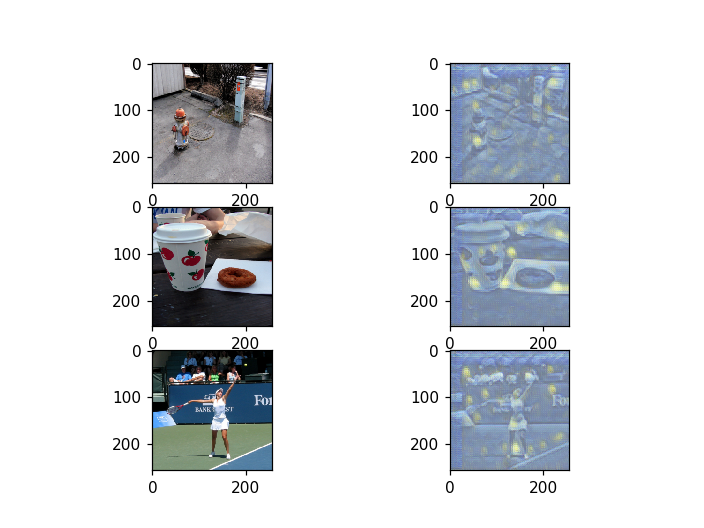

In [30]:
plt.figure(1)
plt.subplot(3,2,1)
plt.imshow(recover_image(x.detach().cpu().numpy())[0])

plt.subplot(3,2,2)
plt.imshow(recover_image(out_img_x.detach().cpu().numpy())[0])

plt.subplot(3,2,3)
plt.imshow(recover_image(y.detach().cpu().numpy())[0])

plt.subplot(3,2,4)
plt.imshow(recover_image(out_img_y.detach().cpu().numpy())[0])

plt.subplot(3,2,5)
plt.imshow(recover_image(z.detach().cpu().numpy())[0])

plt.subplot(3,2,6)
plt.imshow(recover_image(out_img_z.detach().cpu().numpy())[0])
